In [1]:
# Basics
import numpy as np
import json
from tqdm import tqdm
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Custom
import sys
sys.path.insert(0, '../src/utils')
from data_loader import DataLoader, SplitDataLoader
import helpers
import constants
import results
sys.path.insert(0, '../src/modeling')
from network import Network

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
# Basic
import random
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import L1, L2, L1L2

# Custom
import sys
sys.path.insert(0, '../src/utils')
import aes
import constants


class NoRegNetwork():

    """
    Neural Network implementation.
    
    Attributes:
        - model_type (str):
            Type of Neural Network to implement.
        - hp (dict):
            Neural Network hyperparameters.
        - model (keras.models.Sequential):
            Neural Network model.
            By default, it is an empty Sequential object.
        - callbacks (keras.callbacks list):
            List of callbacks to use during model training.
            By default, EarlyStopping and ReduceLROnPlateau are considered.
            
    Methods:
        - add_checkpoint_callback:
            Adds ModelCheckpoint to the list of callbacks.
        - build model:
            Generates the Neural Network model.
        - _compute_key_preds:
            Converts target-predictions into key-predictions.
        - _compute_final_rankings:
            Generates the final ranking of all possible key-bytes.
        - ge:
            Computes the Guessing Entropy of an attack.
    """

    def __init__(self, model_type, hp):

        """
        Class constructor: takes as input all class attributes and generates a
        Network object.
        """
    
        self.model_type = model_type
        self.hp = hp
        self.model = Sequential()
        
        self.callbacks = [
            EarlyStopping(
                monitor='val_loss', 
                patience=15
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=7,
                min_lr=1e-7),
        ]
        

    def add_checkpoint_callback(self, model_path):
    
        """
        Adds ModelCheckpoint to the list of callbacks.
        
        ModelCheckpoint allows to save the best-performing model during training
        (performance is given by the validation loss (the lower, the better)).
        
        Parameters:
            - model_path (str):
                Path to where to store the model (model is a H5 file).
        """
        
        self.callbacks.append(
            ModelCheckpoint(
                model_path,
                monitor='val_loss',
                save_best_only=True
            )
        )


    def build_model(self):
    
        """
        Generates the Neural Network model adding layer to the default empty
        Sequential object.
        
        Different models can be generated: MultiLayer Perceptron (MLP) or 
        Convolutional Neural Network (CNN).
        """

        if self.model_type == 'MLP':
        
            #### Architecture: ####
            # Input Dense         #
            #                     #
            # repeat(             #
            #   Hidden Dense      #
            # )                   # 
            #                     #
            # Output Dropout      #
            #######################
    
            # Input Dense
            self.model.add(Dense(constants.TRACE_LEN, activation='relu'))

            # Hidden
            for _ in range(self.hp['hidden_layers']):
                # Hidden Dense
                self.model.add(Dense(
                    self.hp['hidden_neurons'], 
                    activation='relu')
                )

            # Output
            self.model.add(Dense(256))
            self.model.add(Activation('softmax'))
            
            # Compilation
            lr = self.hp['learning_rate']
            if self.hp['optimizer'] == 'adam':
                opt = Adam(learning_rate=lr)
            elif self.hp['optimizer'] == 'rmsprop':
                opt = RMSprop(learning_rate=lr)
            else:
                opt = SGD(learning_rate=lr)
            
            self.model.compile(
                optimizer=opt, 
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
    
        else:
            pass # In future there will be CNN

In [3]:
def plot_history(history, output_path):
    
    """
    Plots the training history (train_loss vs val_loss, train_acc vs val_acc).
    
    Parameters:
        - history (dict):
            Train history.
        - output_path (str):
            Absolute path to the PNG file containing the plot.
    """
    
    f, ax = plt.subplots(1, 2, figsize=(18,8))
    
    ax[0].plot(history['loss'], label='train_loss')
    ax[0].plot(history['val_loss'], label='val_loss')
    ax[0].set_title('Train and Val Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    ax[0].grid()
    
    ax[1].plot(history['accuracy'], label='train_acc')
    ax[1].plot(history['val_accuracy'], label='val_acc')
    ax[1].set_title('Train and Val Acc')
    ax[1].set_ylabel('Acc')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    ax[1].grid()
    
    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)
    
    
def plot_conf_matrix(conf_matrix, output_path):
    
    cmap = plt.cm.Blues
    
    f = plt.figure(figsize=(10,8))
    
    plt.imshow(conf_matrix, cmap=cmap)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    
    plt.colorbar()
    
    f.savefig(
        output_path,
        bbox_inches='tight',
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)
    
    
def plot_ge(ge, output_path):

    """
    Plots the provided GE vector.
    
    Parameters:
        - ge (np.array):
            GE vector to plot.
        - output_path (str):
            Absolute path to the PNG file containing the plot.
    """
    
    ge = ge[:15]
    
    # Plot GE
    f, ax = plt.subplots(figsize=(15,8))
    
    ax.plot(ge, marker='o', color='b')
        
    ax.set_title(f'Train Devices: D1, D2  |  Test Device: D3')
    ax.set_xticks(range(len(ge)), labels=range(1, len(ge)+1)) 
    ax.set_xlabel('Number of traces')
    ax.set_ylabel('GE')
    ax.grid()

    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)

In [4]:
RES_ROOT = f'{constants.RESULTS_PATH}/DKTA/SBOX_OUT/byte5/1d' 
HP_PATH = RES_ROOT + '/hp.json'

SINGLE_ATTACK_FOLDER = f'{constants.RESULTS_PATH}/SingleAttack_6thByte/NoRegularization'
MODEL_PATH = SINGLE_ATTACK_FOLDER + f'/no_reg_model_b5.h5'
HISTORY_PATH = SINGLE_ATTACK_FOLDER + '/no_reg_train_history.png'
CONF_MATRIX_PATH = SINGLE_ATTACK_FOLDER + '/no_reg_conf_matrix.png'
GE_FILE_PATH = SINGLE_ATTACK_FOLDER + '/no_reg_ge.npy'
GE_PLOT_PATH = SINGLE_ATTACK_FOLDER + '/no_reg_ge.png'

TRAIN_DEVS = ['D1']
ATTACKED_CONFIG = 'D3-K0'

### Training NO-REG

In [5]:
# Get train data
train_configs = [f'{d}-{k}' for k in list(constants.KEYS)[1:]
                 for d in TRAIN_DEVS]

train_dl = SplitDataLoader(
    train_configs, 
    n_tot_traces=50000,
    train_size=0.9,
    target='SBOX_OUT',
    byte_idx=5
)
train_data, val_data = train_dl.load()
x_train, y_train, _, _ = train_data 
x_val, y_val, _, _ = val_data


# Get hyperparameters
with open(HP_PATH, 'r') as jfile:
    hp = json.load(jfile)


# Train and save the model
net = NoRegNetwork('MLP', hp)
net.build_model()
net.add_checkpoint_callback(MODEL_PATH)
model = net.model

history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=net.hp['batch_size'],
    callbacks=net.callbacks,
    verbose=0
).history

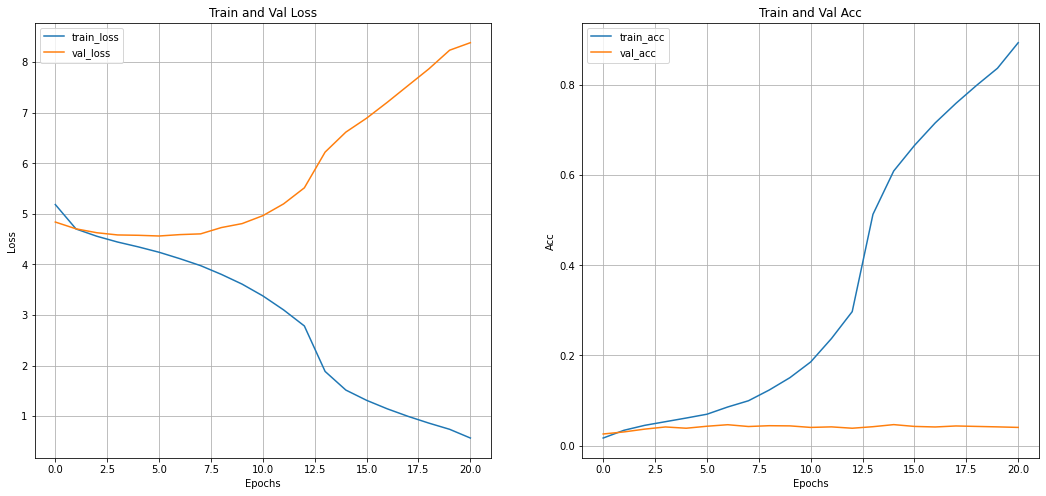

In [6]:
plot_history(history, HISTORY_PATH)

## Attack NO-REG

In [7]:
attack_dl = DataLoader(
    [ATTACKED_CONFIG], 
    n_tot_traces=5000,
    target='SBOX_OUT',
    byte_idx=5
)
x_attack, y_attack, pbs_attack, tkb_attack = attack_dl.load()

attack_model = load_model(MODEL_PATH)
preds = attack_model.predict(x_attack)

### Attack Loss & Attack Accuracy

In [8]:
attack_loss, attack_acc = attack_model.evaluate(x_attack, y_attack, verbose=0)

print(f'Attack Loss:     {attack_loss:.2f}')
print(f'Attack Accuracy: {(attack_acc*100):.2f}%')

Attack Loss:     4.65
Attack Accuracy: 4.24%


### Confusion Matrix

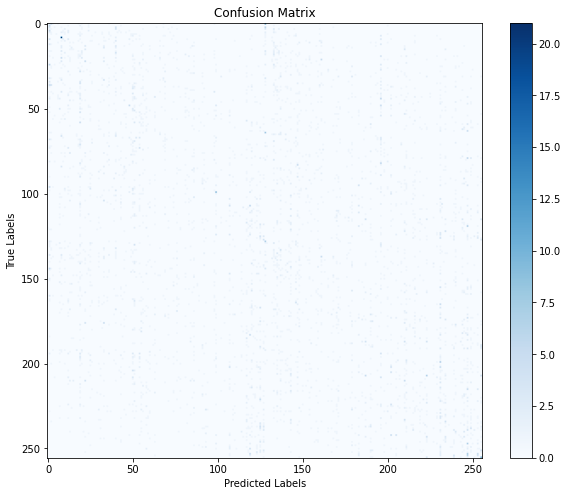

In [9]:
# From one-hot-encoding to true labels in [0;255]
y_true = [el.tolist().index(1) for el in y_attack] 
y_pred = [el.tolist().index(max(el)) for el in preds]

conf_matrix = confusion_matrix(y_true, y_pred)

plot_conf_matrix(conf_matrix, CONF_MATRIX_PATH)

### Guessing Entropy

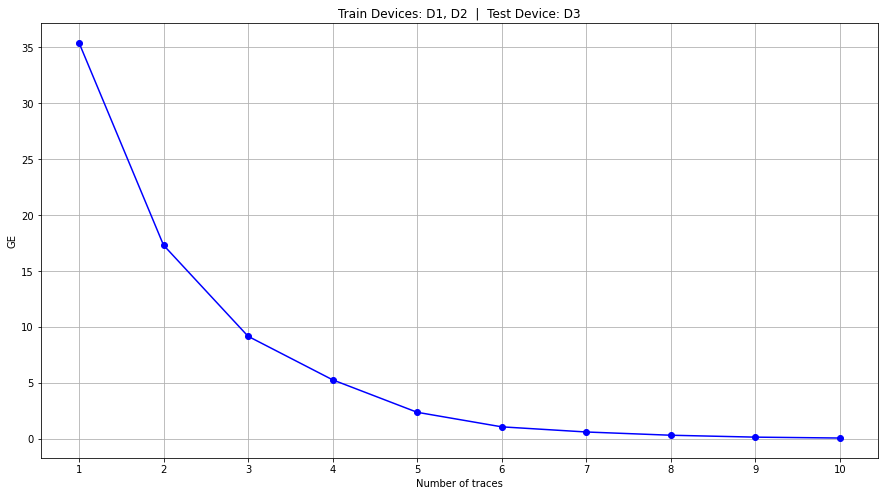

In [10]:
ge = results.ge(
    preds=preds, 
    pltxt_bytes=pbs_attack, 
    true_key_byte=tkb_attack, 
    n_exp=100, 
    target='SBOX_OUT',
    n_traces=10
)

np.save(GE_FILE_PATH, ge)

plot_ge(ge, GE_PLOT_PATH)

### Byte Recovery

In [11]:
ATTACKED_KEY = np.array([int(kb, 16) for kb in constants.KEYS['K0']])
BYTE_6 = ATTACKED_KEY[5]

predicted_byte_inc_traces = results.retrieve_key_byte(
    preds=preds, 
    pltxt_bytes=pbs_attack,  
    target='SBOX_OUT',
    n_traces=100
).tolist()

correct_byte_idx = predicted_byte_inc_traces.index(BYTE_6)
predicted_byte = predicted_byte_inc_traces[correct_byte_idx]

print(f'Predicted 6th Byte: {predicted_byte}')
print(f'Correct 6th Byte:   {BYTE_6}')

print(correct_byte_idx)

Predicted 6th Byte: 253
Correct 6th Byte:   253
2
